## Cleaning the original data

In [1]:
import pandas as pd

df = pd.read_csv("../src/taxipred/data/taxi_trip_pricing.csv")

### Fill missing values with mean and median values for each column, exept target column (Trip_Price)

In [2]:
df_clean = df.copy()

# lägger till mean eller median för varje numerisk kolumn beroende på om det finns mycket outliers eller inte
col_funcs = {"Trip_Distance_km": "median", "Passenger_Count": "median", "Base_Fare": "mean","Per_Km_Rate": "median", "Per_Minute_Rate": "mean", "Trip_Duration_Minutes": "median"}

# loopar igenom och ändrar nullvärden till mean eller median
for col, func in col_funcs.items():
    if func == "median":
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    if func == "mean":
        df_clean[col] = df_clean[col].fillna(df_clean[col].mean())

# hämtar ut resterande kolumner som inte är numeriska
object_cols = ["Time_of_Day", "Day_of_Week", "Traffic_Conditions", "Weather"]

# loopar igenom dessa och hämtar ut det mest återkommande värdet för varje kolumn, och fyller i detta värde vid nullvärden
for col in object_cols:
    mode_value = df_clean[col].mode()[0]
    df_clean[col] = df_clean[col].fillna(mode_value)

### Divide the df into one df with missing target values and one df with the rest

In [3]:
# spara för senare prediction vid user input efter modellen är färdig
df_no_price = df_clean[df_clean["Trip_Price"].isna()]

# spara alla rader där Trip_Price har ett värde, fortsätt rengöra denna
df_clean = df_clean[df_clean["Trip_Price"].notna()]

### Check and remove outliers

<Axes: >

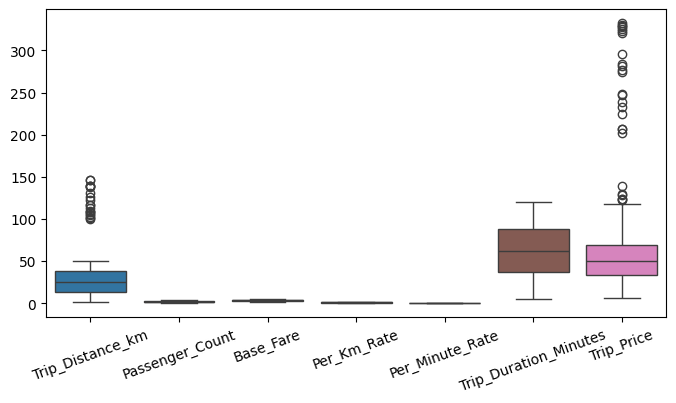

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(1, figsize=(8,4), dpi=100)
plt.xticks(rotation=20)
sns.boxplot(df_clean)

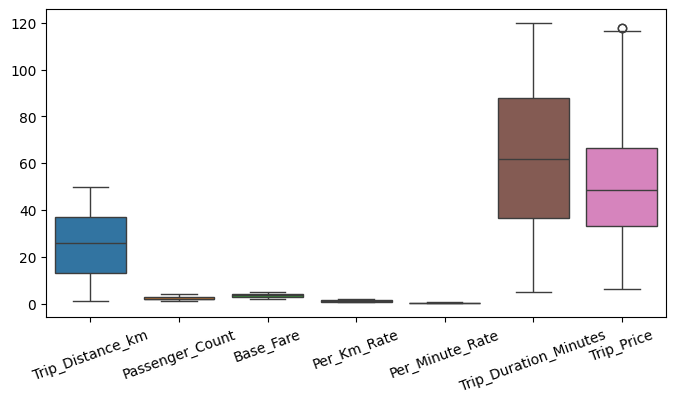

In [5]:
for col in ["Trip_Price", "Trip_Distance_km"]:

    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
        
    df_clean = df_clean[
        (df_clean[col] >= lower_bound) &
        (df_clean[col] <= upper_bound)
    ]
    
plt.subplots(1, figsize=(8,4), dpi=100)
plt.xticks(rotation=20)
sns.boxplot(df_clean);

### Divide the dataset with no missing target values into one with and one without categorical columns

In [6]:
df = df_clean.drop(columns=["Time_of_Day", "Day_of_Week", "Traffic_Conditions", "Weather"])

### Export the datasets into separate .csv files

In [ ]:
# df_clean.to_csv("../src/taxipred/data/taxi_trip_pricing_cleaned_categorical.csv")

df_no_price.to_csv("../src/taxipred/data/missing_target_data.csv")

# df.to_csv("../src/taxipred/data/taxi_trip_pricing_cleaned.csv")

# Clean data with Random Forest imputations

In [8]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv("../src/taxipred/data/taxi_trip_pricing.csv")

### Drop rows where target column has missing values

In [9]:
df = df[df["Trip_Price"].notna()]

### Drop categorical columns

In [10]:
cat_cols = df.select_dtypes(include="object").columns
df = df.drop(columns=cat_cols)

### Fill missing values in the remaining columns

In [11]:
imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=100, random_state=42),
    max_iter=10,
    random_state=42
)

df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

c:\Users\organ\Repos\ml_ai\taxi-prediction-fullstack-pontus\.venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### Check and remove outliers

<Axes: >

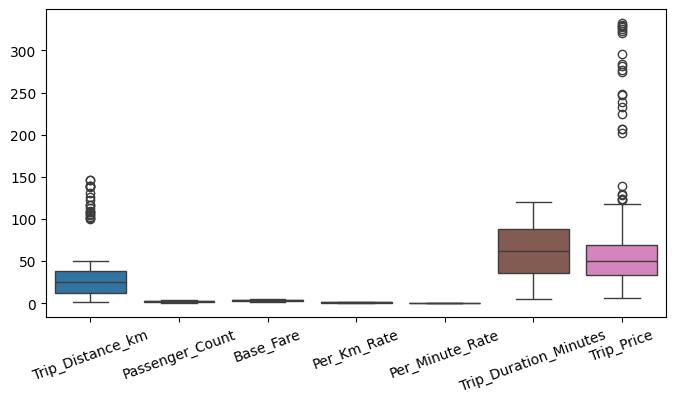

In [12]:
plt.subplots(1, figsize=(8,4), dpi=100)
plt.xticks(rotation=20)
 
sns.boxplot(df_imputed)

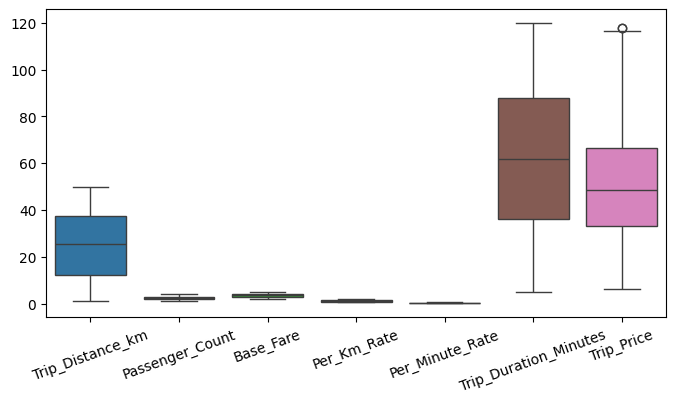

In [13]:
for col in ["Trip_Price", "Trip_Distance_km"]:

    Q1 = df_imputed[col].quantile(0.25)
    Q3 = df_imputed[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
        
    df_imputed = df_imputed[
        (df_imputed[col] >= lower_bound) &
        (df_imputed[col] <= upper_bound)
    ]
    
plt.subplots(1, figsize=(8,4), dpi=100)
plt.xticks(rotation=20)
sns.boxplot(df_imputed);

### Export the last dataset to csv

In [14]:
df_imputed.to_csv("../src/taxipred/data/cleaned_taxi_data.csv")